# **Methodology**

In this notebook, I embark on the mission of identifying and classifying malarial cells using deep learning, specifically leveraging the power of Convolutional Neural Networks (CNNs). The challenge at hand is distinguishing between parasitized cells, which have been invaded by the malaria-causing Plasmodium parasite, and uninfected, healthy cells.

My approach can be summarized as follows:

1. **Data Preprocessing**: Before feeding the cell images into the CNN, I undergo a preprocessing stage. This ensures the images are of a consistent size and are normalized, making them more amenable to deep learning.

2. **Model Architecture**: I employ a CNN architecture, given its proven success in image classification tasks. The hierarchical nature of CNNs enables them to capture both local features, such as shapes and textures within the cell images, and more global features, making them particularly suited for this task.

3. **Training & Validation**: The dataset is split into training and validation sets. The CNN model is trained on the training set, learning to recognize patterns indicative of parasitization. The validation set helps in tuning and avoiding overfitting.

4. **Evaluation**: After training, the model's performance is evaluated using various metrics to determine its accuracy, sensitivity, and specificity in classifying malarial cells.

The ultimate goal is to provide a reliable, automated method for detecting malarial infection in cell images, which can greatly aid in timely diagnosis and treatment.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Library and Module Imports**


In [2]:
import sys
sys.path.append('/content/drive/My Drive/MalariaPred/Scripts')

import imports  # This will import all the modules and functions defined in imports.py

# **Download Dataset from Kaggle**

* Upload the kaggle.json File to Colab:

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


* Move and Set Permissions for kaggle.json:

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
%run '/content/drive/My Drive/MalariaPred/Scripts/download_dataset.py'

Unzipping the dataset...
Dataset downloaded and extracted successfully.


# **Data Preprocessing and Loading**


In [6]:
import sys
sys.path.append('/content/drive/My Drive/MalariaPred')

# Import Image Processing utilities
from Utilities.image_processing import process_images_from_directory

In [7]:
# Define constants and initialize lists
BASE_PATH = imports.Path('/content/cell_images')

SIZE = 64
label = []
dataset = process_images_from_directory(BASE_PATH/'Parasitized', label, SIZE)
dataset.extend(process_images_from_directory(BASE_PATH/'Uninfected', label, SIZE))

* Data Exploratory Analysis (EDA)

In [8]:
# Import EDA utilities
from Utilities.eda_utils import display_samples, plot_class_distribution

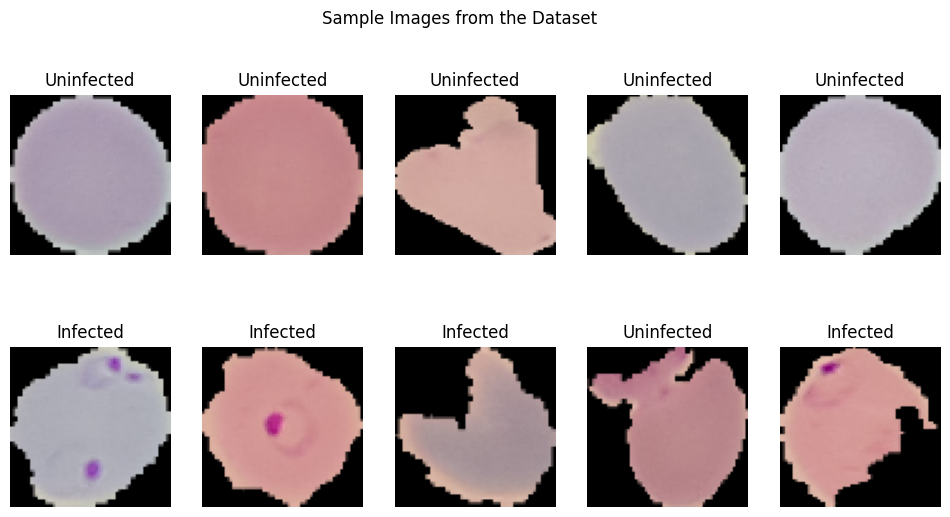

In [9]:
# Perform EDA
samples_to_display = 10

random_indices = imports.np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

# Example usage
display_samples(samples, sample_labels, "Sample Images from the Dataset")

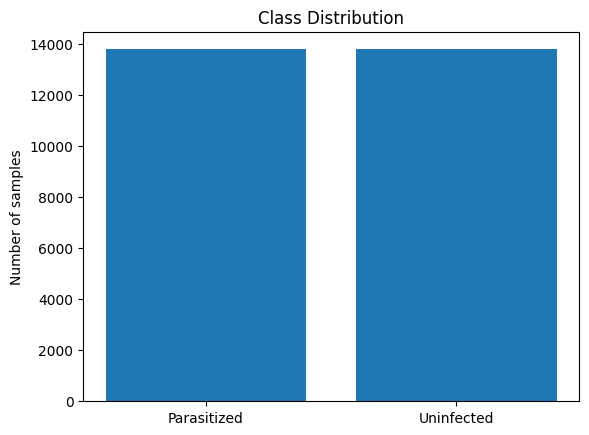

In [10]:
plot_class_distribution(label, "Class Distribution")

# **Model Architecture**


* Define Convolutional Block Function

In [11]:
def conv_block(input_tensor, num_filters):
    """
    Adds a convolutional block to the model.

    Parameters:
    - input_tensor: Input tensor to the convolutional block
    - num_filters: Number of filters for the convolutional layers

    Returns:
    - Tensor after applying convolutional layers, MaxPooling, BatchNormalization, and Dropout
    """
    x = imports.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=imports.l2(0.001))(input_tensor)
    x = imports.MaxPooling2D(pool_size=(2, 2))(x)
    x = imports.BatchNormalization()(x)
    x = imports.Dropout(0.3)(x)
    return x

* Define Dense Block Function

In [12]:
def dense_block(input_tensor, num_neurons):
    """
    Adds a dense block to the model.

    Parameters:
    - input_tensor: Input tensor to the dense block
    - num_neurons: Number of neurons in the dense layer

    Returns:
    - Tensor after applying Dense layer, BatchNormalization, and Dropout
    """
    x = imports.Dense(num_neurons, activation='relu', kernel_regularizer=imports.l2(0.001))(input_tensor)
    x = imports.BatchNormalization()(x)
    x = imports.Dropout(0.3)(x)
    return x


In [13]:
# Define the input shape
INPUT_SHAPE = (SIZE, SIZE, 3)

# Input layer
inp = imports.Input(shape=INPUT_SHAPE)

# Creating convolutional blocks
x = conv_block(inp, 32)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 64)

# Flattening and dense layers
x = imports.Flatten()(x)
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer for binary classification
out = imports.Dense(2, activation='softmax')(x)

# Create and compile the model
model = imports.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       imports.tf.keras.metrics.Precision(name='precision'),
                       imports.tf.keras.metrics.Recall(name='recall')])

# Print model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

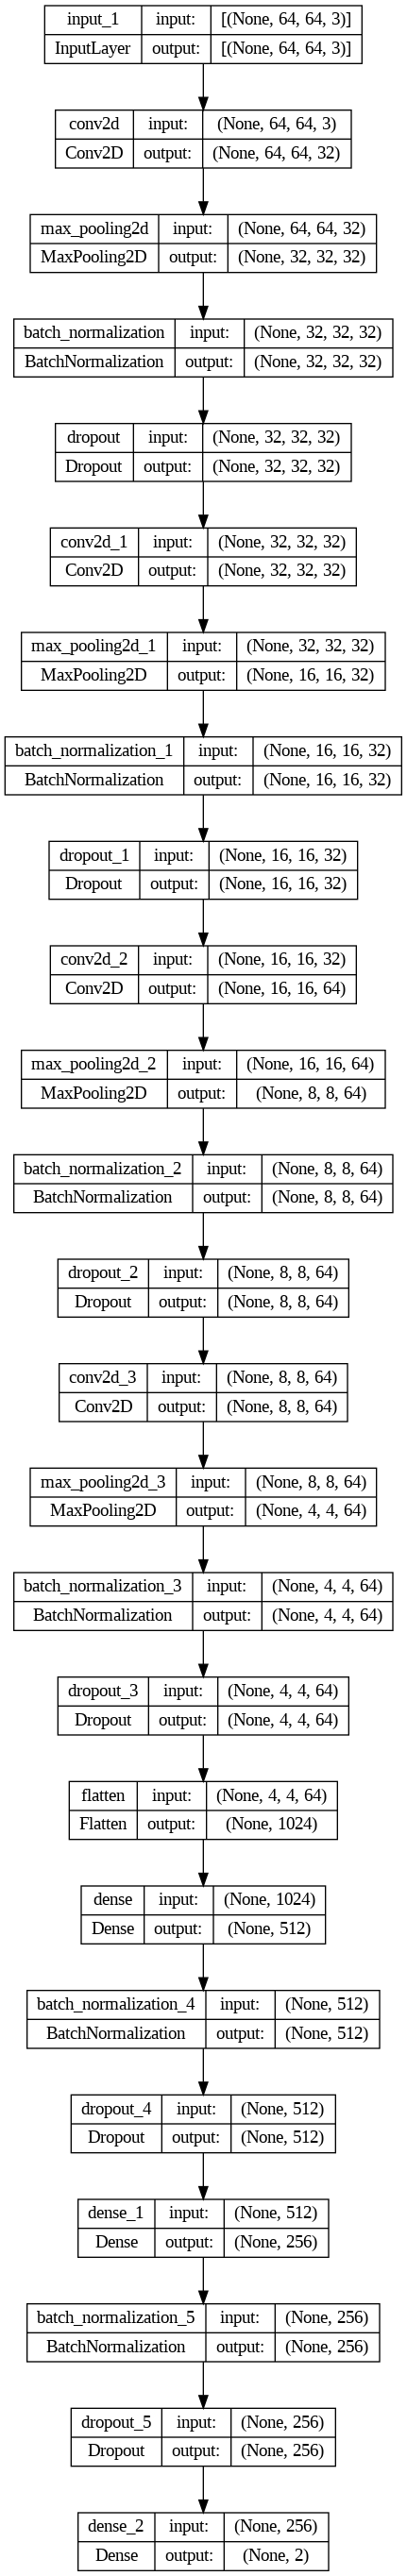

In [14]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image
from IPython.display import Image
Image(filename='model_architecture.png')

#**Training & Validation**

* Prepare the Data

In [15]:
# Splitting the Dataset
X = imports.np.array(dataset)
Y = imports.to_categorical(imports.np.array(label))
X_train_val, X_test, y_train_val, y_test = imports.train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val  = imports.train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# 60% training set, 20% validation set, 20% test set

* Data Augmentation

In [16]:
# Define the ImageDataGenerator
data_generator = imports.ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.1,
    height_shift_range= 0.1,
    zoom_range        = 0.1,
    horizontal_flip   = True,
    vertical_flip     = True
)


# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


In [18]:
early_stopping = imports.EarlyStopping(monitor='val_loss', patience = 5)

# Training the Model
history = model.fit(
    augmented_data,
    verbose = 1,
    epochs  = 30,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // 64,  # Number of batches per epoch
    callbacks=[early_stopping]
)

Epoch 1/30
344/344 [==============================] - 117s 334ms/step - loss: 1.4133 - accuracy: 0.8307 - precision: 0.8307 - recall: 0.8307 - val_loss: 1.0352 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263
Epoch 2/30
344/344 [==============================] - 117s 340ms/step - loss: 0.7756 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - val_loss: 0.7341 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231
Epoch 3/30
344/344 [==============================] - 114s 331ms/step - loss: 0.4822 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - val_loss: 0.5167 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 4/30
344/344 [==============================] - 118s 344ms/step - loss: 0.3529 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - val_loss: 0.3249 - val_accuracy: 0.9358 - val_precision: 0.9358 - val_recall: 0.9358
Epoch 5/30
344/344 [==============================] - 111s 322ms/step - loss: 0.2956 - a

In [19]:
# Evaluate the model
scores = model.evaluate(imports.np.array(X_test), imports.np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(imports.np.array(X_test))
predicted_classes = imports.np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = imports.np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(imports.classification_report(y_test_single_column, predicted_classes))
print(imports.confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 96.03%
Test Loss: 0.19740
173/173 [==============================] - 6s 31ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2797
           1       0.94      0.98      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512

[[2639  158]
 [  61 2654]]


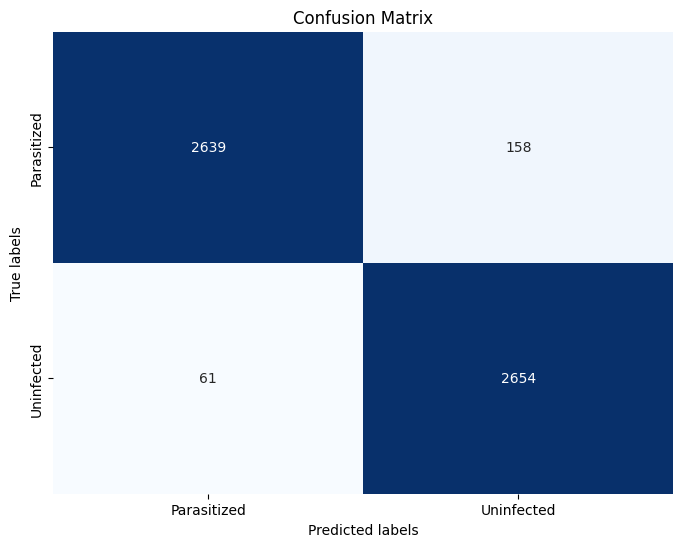

In [20]:
# Calculate the confusion matrix
conf_matrix = imports.confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()


In [21]:
# Calculate the average training loss over all epochs
average_train_loss = imports.np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.38031
Final Training Loss: 0.22643


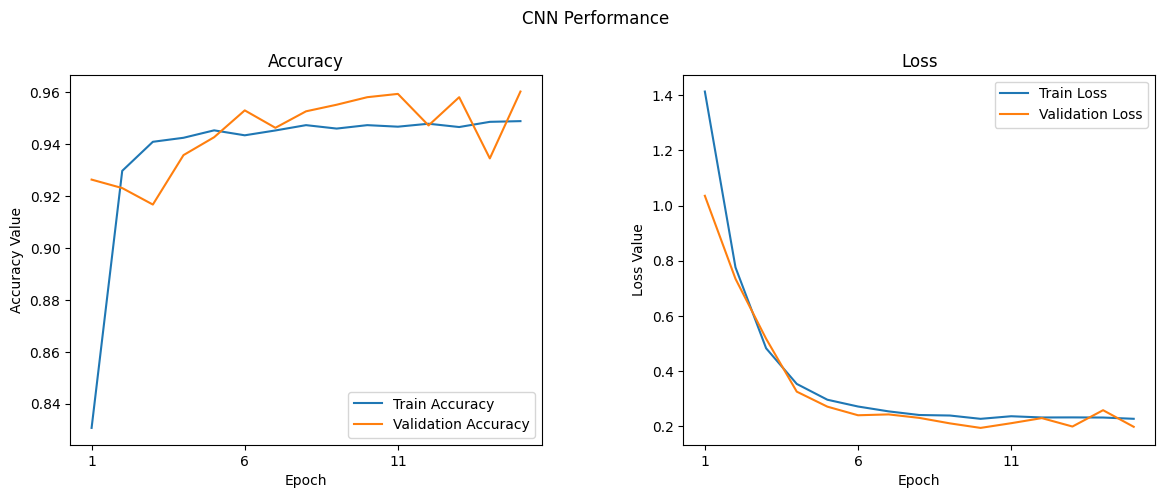

In [22]:
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(imports.np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(imports.np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)

**Evaluating Model Discrimination Power**

In [23]:
# Get the predicted probabilities for the positive class (1)
y_pred_probs = model.predict(X_test)[:, 1]  # Assuming the second neuron corresponds to the positive class

173/173 [==============================] - 7s 39ms/step


In [24]:
from sklearn.metrics import roc_curve, auc

# Calculate the Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(y_test_single_column, y_pred_probs)

# Calculate the Area Under the ROC Curve (AUC) score
roc_auc = auc(fpr, tpr)
print(f'AUC Score: {roc_auc:.2f}')

AUC Score: 0.99


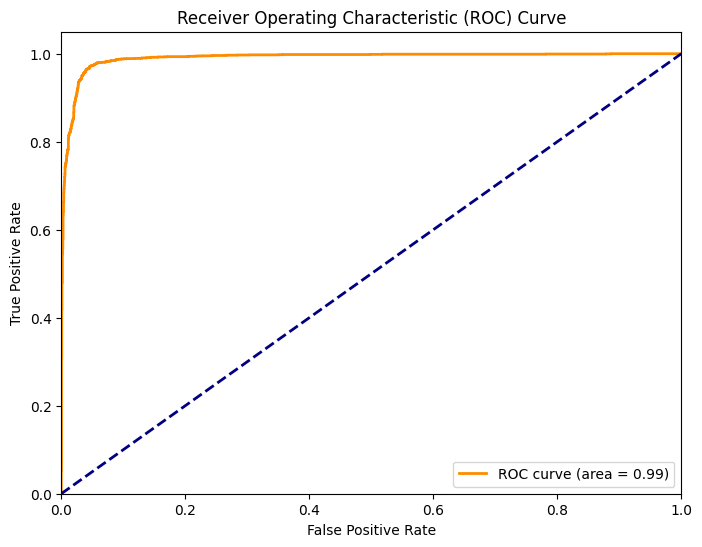

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Archiving the Model**

In [26]:
import os

# Define the model directory
model_dir = '/content/drive/My Drive/MalariaPred/Models'

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'malaria_cnn.h5')
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Visual Inspection of Model Predictions**

1/1 [==============================] - 0s 19ms/step


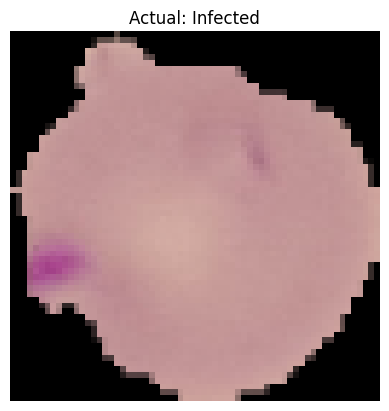

Predicted: Infected


In [27]:
# Define a mapping from class indices to human-readable class names
class_mapping = {0: "Infected", 1: "Uninfected"}

# Randomly pick an index from the test set
sample_index = imports.np.random.choice(len(X_test))
# Retrieve the corresponding image and label from the test set
sample_image = X_test[sample_index]
sample_label = y_test[sample_index]  # Use sample_index to retrieve the label

# Generate model predictions for the sample image
predictions = model.predict(imports.np.expand_dims(sample_image, axis=0))

# Determine the actual and predicted classes
actual_class = imports.np.argmax(sample_label)
predicted_class_idx = imports.np.argmax(predictions, axis=1)[0]

# Display the sample image
plt.imshow(sample_image)
# Title with the actual class
plt.title(f"Actual: {class_mapping[actual_class]}")
plt.axis("off")  # Hide the axis to focus on the image
plt.show()

# Print the predicted class
print(f"Predicted: {class_mapping[predicted_class_idx]}")
